In [1]:
import matplotlib.pyplot as plt
import numpy as np
from tqdm import tqdm  # tqdm是显示循环进度条的库
from IPython import display
import import_ipynb
from util import utils

# 环境

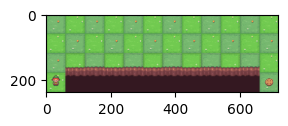

In [2]:
env = utils.CliffWalkingEnv(max_step=200)
env.reset(seed=0)
env.show()

# 算法定义

In [3]:
class NStepSarsa:
    """ n步Sarsa算法 """
    name = 'NStepSarsa'
    def __init__(self, n, state_dim, epsilon, alpha, gamma, action_dim):
        self.Q_table = np.zeros([state_dim, action_dim])
        self.action_dim = action_dim
        self.alpha = alpha
        self.gamma = gamma
        self.epsilon = epsilon
        self.n = n  # 采用n步Sarsa算法
        self.state_list = []  # 保存之前的状态
        self.action_list = []  # 保存之前的动作
        self.reward_list = []  # 保存之前的奖励
        self.nrow = action_dim
        self.ncol = state_dim // action_dim

    def take_action(self, state):
        if np.random.random() < self.epsilon:
            action = np.random.randint(self.action_dim)
        else:
            action = np.argmax(self.Q_table[state])
        return action

    def update(self, transition_dict):
        s0 = transition_dict['state']
        a0 = transition_dict['action']
        r = transition_dict['reward']
        s1 = transition_dict['next_state']
        a1 = transition_dict['next_action']
        done = transition_dict['done']
        self.state_list.append(s0)
        self.action_list.append(a0)
        self.reward_list.append(r)
        if len(self.state_list) == self.n:  # 若保存的数据可以进行n步更新
            G = self.Q_table[s1, a1]  # 得到Q(s_{t+n}，a_{t+n})
            for i in reversed(range(self.n)):
                G = self.gamma * G + self.reward_list[i]  # 不断向前计算每一步的回报
                # 如果到达终止状态，最后几步虽然长度不够n步，也将其进行更新
                if done and i > 0:
                    s = self.state_list[i]
                    a = self.action_list[i]
                    self.Q_table[s, a] += self.alpha * (G - self.Q_table[s, a])
            s = self.state_list.pop(0)  # 将需要更新的状态动作从列表中删除，下次不必更新
            a = self.action_list.pop(0)
            self.reward_list.pop(0)
            # n步Sarsa的主要更新步骤
            self.Q_table[s, a] += self.alpha * (G - self.Q_table[s, a])
        if done:  # 如果到达终止状态，即将开始下一条序列，则将列表全清空
            self.state_list = []
            self.action_list = []
            self.reward_list = []
            
    def play(self, env, update=False, show=False):
        episode_return = 0
        state = env.reset()
        action = self.take_action(state)
        done = False
        while not done:
            next_state, reward, done = env.step(action)
            next_action = self.take_action(next_state)
            episode_return += reward  # 这里回报的计算不进行折扣因子衰减
            if show:
                display.clear_output(wait=True)
                env.show()
            if update:
                transition_dict = {
                    'state': state,
                    'action': action,
                    'reward': reward,
                    'next_state': next_state,
                    'next_action': next_action,
                    'done': done
                }
                self.update(transition_dict)
            state = next_state
            action = next_action
        return episode_return 
        
    def show_q_table(self):
        for nrow in range(self.nrow):
            for ncol in range(self.ncol):
                print(np.argmax(self.Q_table[nrow * 12 + ncol]), end='    ')
            print()

# 初始化

In [4]:
np.random.seed(0)

In [5]:
state_dim = env.observation_space.n
action_dim = env.action_space.n
n_step = 5  # 5步Sarsa算法
alpha = 0.1
epsilon = 0.1
gamma = 0.9
agent = NStepSarsa(n_step, state_dim, epsilon, alpha, gamma, action_dim)

In [6]:
num_episodes = 500  # 智能体在环境中运行的序列的数量
epochs = 10

# 玩一局游戏（训练前）

In [7]:
agent.show_q_table()

0    0    0    0    0    0    0    0    0    0    0    0    
0    0    0    0    0    0    0    0    0    0    0    0    
0    0    0    0    0    0    0    0    0    0    0    0    
0    0    0    0    0    0    0    0    0    0    0    0    


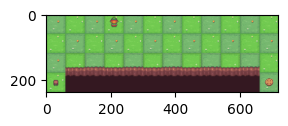

回报：-200


In [8]:
episode_return = agent.play(env, update=False, show=True)
print("回报：{}".format(episode_return))

# 算法训练

## 训练过程

In [9]:
def train(env, agent, num_episodes, epochs):
    return_list = [] # 记录每一条序列的回报
    update = True
    show = False
    for i in range(epochs): # 显示epochs个进度条
        with tqdm(total=int(num_episodes / epochs), desc='Iteration %d' % i) as pbar:
            for i_episode in range(int(num_episodes / epochs)):  # 每个进度条的序列数
                episode_return = agent.play(env, update, show)
                return_list.append(episode_return)
                if (i_episode + 1) % 10 == 0:  # 每10条序列打印一下这10条序列的平均回报
                    pbar.set_postfix({
                        'episode': '%d' % (num_episodes / 10 * i + i_episode + 1),
                        'return': '%.3f' % np.mean(return_list[-10:])
                    })
                pbar.update(1)
    return return_list

In [10]:
return_list = train(env=env, agent=agent, num_episodes=num_episodes, epochs=epochs)

Iteration 9: 100%|██████████████████████████████████████| 50/50 [00:00<00:00, 1467.64it/s, episode=500, return=-20.500]


## 训练结果

### 训练回报

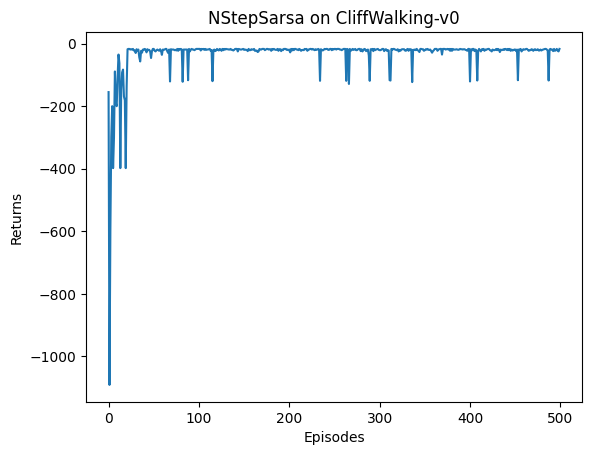

In [11]:
utils.show_return(return_list, agent, env)

### 移动平均训练回报

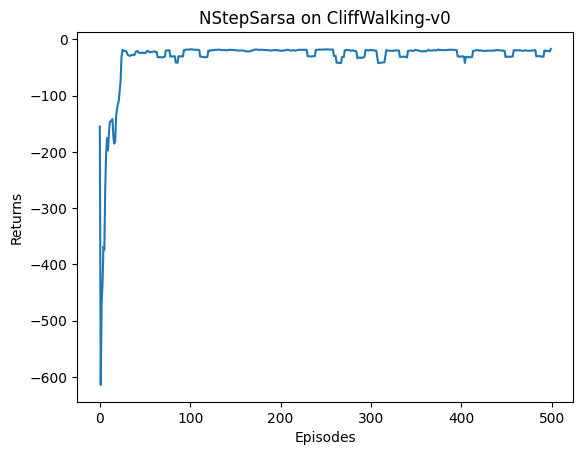

In [12]:
mv_return = utils.moving_average(return_list, 9)
utils.show_return(mv_return, agent, env)

# 再玩一局游戏（训练后）

In [13]:
agent.show_q_table()

1    1    1    1    1    1    1    1    1    1    1    2    
1    1    0    3    1    0    3    3    1    0    0    2    
0    0    3    0    0    1    3    1    3    0    0    2    
0    0    0    0    0    0    0    0    0    0    0    0    


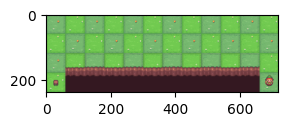

回报：-17


In [14]:
episode_return = agent.play(env, update=False, show=True)
print("回报：{}".format(episode_return))